In [25]:
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import os
from time import sleep

import matplotlib.pyplot as plt
import cv2
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import PIL.Image as Image

from dataset import *
from utilities import *
from resnet import *
from config import *

In [27]:
color_to_gray_map, gray_to_color_map = None, None

In [28]:
np.random.seed(0)
train_imageset_path = '../trainval/DAVIS/ImageSets/2017/train.txt'
val_imageset_path = '../trainval/DAVIS/ImageSets/2017/val.txt'
testd_imageset_path = '../testd/DAVIS/ImageSets/2017/test-dev.txt'
trainval_image_root = '../trainval/DAVIS/JPEGImages/480p/'
trainval_mask_root = '../trainval/DAVIS/Annotations/480p/'
testd_image_root = '../testd/DAVIS/JPEGImages/480p/'
testd_mask_root = '../testd/DAVIS/Annotations/480p/'
models_root = '../models/'

train_list = []
val_list = []
test_list = []

with open(train_imageset_path, 'r') as f:
    for line in f:
        train_list.append(line.strip())
with open(val_imageset_path, 'r') as f:
    for line in f:
        val_list.append(line.strip())
with open(testd_imageset_path, 'r') as f:
    for line in f:
        test_list.append(line.strip())


In [29]:
def eval(image_root, mask_root, target_list):
    
    for t in range(len(target_list)):
        if t != 0:
            continue
        print(target_list[t])
        image_path = os.path.join(image_root, target_list[t] + '/00000.jpg')
        mask_path = os.path.join(mask_root, target_list[t] + '/00000.png')
        model_save_path = os.path.join(models_root, target_list[t] + '.pt')
    
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path)
        PIL_mask = Image.open(mask_path)
        color_to_gray_map, gray_to_color_map = get_map(mask, PIL_mask)
        del PIL_mask
    
        image = cv2.resize(image, Resize, interpolation=cv2.INTER_NEAREST)
        mask = cv2.resize(mask, Resize, interpolation=cv2.INTER_NEAREST)
        print('type_cnt:', len(color_to_gray_map))
        
    
        val_dataset = CustomDataset(image_path, mask_path, image_transform=val_image_transforms, mask_transform=val_mask_transforms, num_samples=1)
        val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    
        model = MyResNet(len(color_to_gray_map)).to(device)
        model.load_state_dict(torch.load(model_save_path))
    
        model.eval()
        for image, mask in val_dataloader:
            mask = (mask * 255).long()
            input = torch.cat((image, mask), dim=1).to(device)
            output_mask = torch.argmax(model(input), dim=1)
            output = model(input)
            loss = F.cross_entropy(output, input[:, 3, :, :].long())
            print(input[:, :3, :, :].mean(), input[:, 3, :, :].mean())
            print(np.where(mask == 1), mask.float().mean(), mask.max())

            print(loss.item(), torch.sum(output_mask == torch.tensor(input[:, 3, :, :]).to(device)).item() / (224 * 224))
            
            mask_np = mask.squeeze(0).cpu().numpy().transpose(1, 2, 0)
            output_mask_np = output_mask.cpu().numpy().transpose(1, 2, 0)
            image_np = image.squeeze(0).numpy().transpose(1, 2, 0)
            print_images([image_np, mask_np, output_mask_np])
            
            return
        

bike-packing
Element 0 has count 363087
Element 1 has count 30321
Element 2 has count 43392
type_cnt: 3
P
Element 0.0 has count 41715
Element 0.003921568859368563 has count 3485
Element 0.007843137718737125 has count 4976
tensor(0.3287, device='cuda:0') tensor(0.2678, device='cuda:0')
(array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([ 77,  77,  78, ..., 223, 223, 223]), array([95, 96, 95, ..., 91, 98, 99])) tensor(0.2678) tensor(2)
0.6751980781555176 0.9057517538265306


/tmp/ipykernel_29746/3943324894.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(loss.item(), torch.sum(output_mask == torch.tensor(input[:, 3, :, :]).to(device)).item() / (224 * 224))


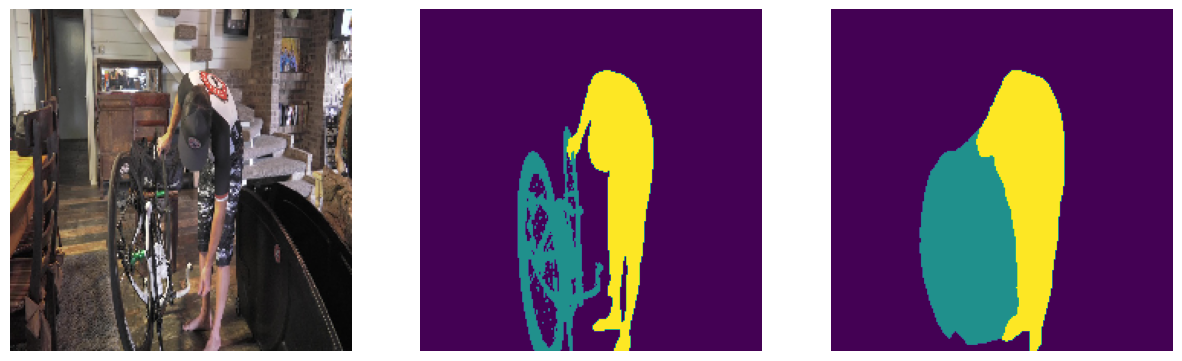

In [30]:
# eval(trainval_image_root, trainval_mask_root, train_list)
eval(trainval_image_root, trainval_mask_root, val_list)
# eval(testd_image_root, testd_mask_root, test_list)